In [1]:
##############################
# IMPORT  https://medium.com/@denizgunay/principal-component-analysis-pca-d8edf2bb6620
##############################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression , mutual_info_classif




In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
def apply_pca(X, standardize=True, n_components=None):
    """
    Apply Principal Component Analysis (PCA) to the input data.

    This function standardizes the input data (optional) and performs PCA to reduce
    dimensionality. It returns the PCA object, a DataFrame with transformed data, and
    a DataFrame with loadings for each PCA component.

    Parameters:
    -----------
    X : pandas.DataFrame
        The input DataFrame containing the features to be analyzed.

    standardize : bool, optional (default=True)
        If True, standardize the input data by subtracting the mean and dividing by the
        standard deviation for each feature.

    n_components : int or None, optional (default=None)
        Number of components to keep. If None, all components are kept.

    Returns:
    --------
    pca : sklearn.decomposition.PCA
        The PCA object that contains information about the PCA transformation.

    X_pca : pandas.DataFrame
        Transformed data with principal components as columns.

    loadings : pandas.DataFrame
        Loadings matrix, indicating the contribution of each original feature to each
        principal component.

    Example:
    --------
    pca, X_pca, loadings = apply_pca(X, standardize=True, n_components=3)
    """
    if X.isnull().sum().sum() != 0:
        print(f"Input dataframe cannot contain any NaN value, but it has {X.isnull().sum().sum()} NaN values.")
        return
    X.replace(np.inf, np.nan, inplace=True)
    max_values = X.max()
    X.fillna(max_values, inplace=True)
    
    X.replace(-np.inf, np.nan, inplace=True)
    min_values = X.min()
    X.fillna(min_values, inplace=True)

    # Standardize
    if standardize:
        cols = X.columns
        X = StandardScaler().fit_transform(X)
        X = pd.DataFrame(X, columns=cols)
    
    # Create principal components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )

    return pca, X_pca, loadings


In [4]:
def plot_pca_variance(pca, width=10, dpi=120):
    """
    Plot Explained Variance and Cumulative Variance graphs for Principal Component Analysis (PCA).

    This function creates two subplots in a single figure. The first subplot displays the
    percentage of explained variance for each principal component, while the second subplot
    shows the cumulative explained variance as more components are added.

    Parameters:
    -----------
    pca : sklearn.decomposition.PCA
        The PCA object obtained from applying PCA to the data.

    width : int, optional (default=10)
        Width of the figure in inches.

    dpi : int, optional (default=120)
        Dots per inch for figure resolution.

    Returns:
    --------
    None

    Example:
    --------
    pca, X_pca, loadings = apply_pca(X, standardize=True, n_components=3)
    plot_pca_variance(pca)
    """

    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, round(10*max(evr)+0.5)/10)
    )
    axs[0].title.set_weight('bold')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[0].set_xticks(grid)
    axs[0].set_xticklabels(grid)

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(grid, cv, "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.01)
    )
    axs[1].title.set_weight('bold')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[1].set_xticks(grid)
    axs[1].set_xticklabels(grid)

    # Cumulative variance value on the 2nd plot
    axs[1].annotate(f'CV={cv[-1]:.3f}', (grid[-1], cv[-1]), textcoords="offset points", xytext=(-15,-10), ha='center')

    # Set up figure
    fig.set(figwidth=width, dpi=dpi)


In [5]:
def plot_mi_scores(X, y, mode="regression", p: int = None):
    """
    Plot Mutual Information (MI) Scores for feature selection.

    This function calculates and displays Mutual Information (MI) Scores for each
    independent feature with respect to the target variable. MI measures the
    dependency between two random variables and is useful for feature selection.

    Parameters:
    -----------
    X : pandas.DataFrame
        The input DataFrame containing the independent features.

    y : array-like
        The target variable.

    mode : str, optional (default="regression")
        The mode of MI Score calculation. Choose from 'regression' or 'classification'.

    p : int or None, optional (default=None)
        Number of top features to display with the highest MI Scores. If None,
        all features are displayed. Should be an integer greater than or equal to 1.

    Returns:
    --------
    None

    Example:
    --------
    plot_mi_scores(X, y, mode="classification", p=5)
    """

    if p is not None:
        if p < 1 or p != int(p):
            print(f"'p' must be at least 1 and an integer.")
            return
        p = int(p)

    if mode not in ['regression', 'classification']:
        print("'mode' parameter can be equal to 'regression' or 'classification'.")
        return
    
    if X.isnull().sum().sum() != 0:
        print(f"Input dataframe cannot contain any NaN value, but it has {X.isnull().sum().sum()} NaN values.")
        return
    
    X = X.copy()
    X.replace(np.inf, np.nan, inplace=True)
    max_values = X.max()
    X.fillna(max_values, inplace=True)
    X.replace(-np.inf, np.nan, inplace=True)
    min_values = X.min()
    X.fillna(min_values, inplace=True)
    
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    if mode == 'regression':
        scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    else:
        scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    scores = pd.Series(scores, name="MI Scores", index=X.columns)
    scores = scores.sort_values(ascending=True)
    
    if p is not None:
        scores = scores[-p:]

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.ylabel("Independent Features")
    plt.title("Mutual Information Scores", fontsize=30)
    plt.show(block=True)


In [6]:
def encode_scale_concate(x1, x2, columns: list, standardize=True, encoder='onehot'):
    """
    Standardize and encode specified columns in x2 DataFrame, then concatenate them with x1.

    This function takes two DataFrames, x1 and x2, and performs the following operations:
    1. Encodes specified columns in x2 using one-hot encoding or label encoding.
    2. Optionally standardizes the encoded columns.
    3. Concatenates the resulting columns from x2 with x1 on a column-by-column basis.

    Parameters:
    -----------
    x1 : pandas.DataFrame
        The first DataFrame to which columns will be added.

    x2 : pandas.DataFrame
        The second DataFrame from which columns will be encoded and scaled.

    columns : list
        List of column names in x2 to be encoded and optionally standardized.

    standardize : bool, optional (default=True)
        If True, standardize the encoded columns.

    encoder : str, optional (default='onehot')
        The encoding method to use for categorical columns. Choose from 'onehot', 'label',
        or None. 'onehot' performs one-hot encoding, 'label' performs label encoding,
        and None skips encoding.

    Returns:
    --------
    x : pandas.DataFrame
        The resulting DataFrame with concatenated and processed columns.

    Example:
    --------
    x_combined = encode_scale_concate(x1, x2, columns=categorical_columns, standardize=True)
    """

    if encoder not in ['onehot', 'label', None]:
        print("'encoder' parameter can be equal to 'onehot', 'label', or None.")
        return

    if encoder == 'onehot':
        add_df = pd.get_dummies(x2[columns], drop_first=True)
    elif encoder == 'label':
        add_df = x2[columns].copy()
        label_encoder = LabelEncoder()
        for col in columns:
            add_df[col] = label_encoder.fit_transform(add_df[col])
    else:
        add_df = x2

    if standardize:
        col_names = add_df.columns
        add_df = StandardScaler().fit_transform(add_df)
        add_df = pd.DataFrame(add_df, columns=col_names)

    x = pd.concat([x1.reset_index(drop=True), add_df.reset_index(drop=True)], axis=1)
    return x


In [7]:
def visualize_pca(pca_df, target, figsize=(12, 10)):
    """
    Visualizes PCA components.

    Args:
        pca_df (DataFrame): a dataFrame consisting of 2 or 3 PCA components.
        target (ndarray or Series): Categorical or numeric target data set.
        figsize (tuple): (width of plot, height of plot).

    Returns:
        None
    """
    label_encoder = None
    
    if not np.issubdtype(target.dtype, np.number):
        # If target is non-numeric, apply label encoding.
        label_encoder = LabelEncoder()
        target = label_encoder.fit_transform(target)
    
    if pca_df.shape[1] == 2:
        # 2D Visualization
        plt.figure(figsize=figsize)
        scatter = plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=target, cmap='viridis', marker='o')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title("2D PCA Visualization", fontweight="bold", fontsize=16)
        plt.colorbar(scatter, label='Target')
        
        # Add legends for non-numeric targets
        if label_encoder is not None:
            unique_targets = np.unique(target)
            handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(k)), markerfacecolor=scatter.cmap(scatter.norm(k)), markersize=10, label=v) for k, v in zip(unique_targets, label_encoder.classes_)]
            plt.legend(handles=handles)
        
        plt.show()
    elif pca_df.shape[1] == 3:
        # 3D Visualization
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], pca_df.iloc[:, 2], c=target, cmap='viridis', marker='o')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title("3D PCA Visualization", fontweight="bold", fontsize=16)
        fig.colorbar(scatter, label='Target')
        
        # Add legends for non-numeric targets
        if label_encoder is not None:
            unique_targets = np.unique(target)
            handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(k)), markerfacecolor=scatter.cmap(scatter.norm(k)), markersize=10, label=v) for k, v in zip(unique_targets, label_encoder.classes_)]
            plt.legend(handles=handles)
        
        plt.show()
    else:
        print("Unsupported number of PCA components. 2 or 3 components are required.")



In [8]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


In [9]:
df = pd.read_csv("./data/231018_clean_table_for_analysis.csv")

C:\Users\tiago\AppData\Local\Temp\ipykernel_25472\4237666586.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/231018_clean_table_for_analysis.csv")


In [10]:
print(df.isna().sum())

Num_Acc             0
place               0
catu                0
sexe                0
an_nais             0
trajet              0
locp                0
an                  0
mois                0
jour                0
lum                 0
agg                 0
int                 0
atm                 0
col                 0
dep                 0
catr                0
circ                0
nbv                 0
vosp                0
prof                0
plan                0
surf                0
infra               0
situ                0
senc                0
catv                0
occutc              0
obs                 0
obsm                0
choc                0
manv                0
date                0
is_holiday          0
holiday       2367768
actp                0
num_veh             0
hrmn                0
grav                0
etatp               0
dtype: int64


In [11]:
df = df.dropna(subset=['holiday'])
print(df.isna().sum())

Num_Acc       0
place         0
catu          0
sexe          0
an_nais       0
trajet        0
locp          0
an            0
mois          0
jour          0
lum           0
agg           0
int           0
atm           0
col           0
dep           0
catr          0
circ          0
nbv           0
vosp          0
prof          0
plan          0
surf          0
infra         0
situ          0
senc          0
catv          0
occutc        0
obs           0
obsm          0
choc          0
manv          0
date          0
is_holiday    0
holiday       0
actp          0
num_veh       0
hrmn          0
grav          0
etatp         0
dtype: int64


In [12]:
print(df.head())

          Num_Acc  place  catu  sexe  an_nais  trajet  locp    an  mois  jour  lum  agg  int  atm  col  dep  catr  circ  nbv  vosp  prof  plan  surf  infra  situ  senc  catv  occutc  obs  obsm  choc  manv        date  is_holiday        holiday  actp  num_veh  hrmn  grav  etatp
488  201900000230    1.0     1     1     2002     5.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   1.0     2    -1.0  0.0   2.0   3.0   1.0  2019-05-30        True  Ascension Day     1       14   965     3      0
489  201900000230    1.0     1     1     2000     9.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   2.0     7    -1.0  0.0   2.0   2.0  15.0  2019-05-30        True  Ascension Day     1        0   965     0      0
511  201900000240    1.0     1     1     1985     5.0   0.0  2019     5     8    1    1    6  2.0  3.0   64   1.0   3.0  2.0   0.0   1.0   1.0   2.0    3.0   1.0   1.

In [13]:
#Numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
print(num_cols)

['Num_Acc', 'place', 'catu', 'sexe', 'an_nais', 'trajet', 'locp', 'an', 'mois', 'jour', 'lum', 'agg', 'int', 'atm', 'col', 'dep', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'is_holiday', 'actp', 'num_veh', 'hrmn', 'grav', 'etatp']


In [14]:
#Nonnumerical columns
non_num_cols = [col for col in df.columns if col not in num_cols]
print(non_num_cols)

['date', 'holiday']


In [16]:
import numpy as np
# create target variable
# create a new variable for the severity ['Grav'] of accidents ( Sereve, non-severe) as a possible target variable
#### 0 = non severe and 1 equal to severe
df['Severe'] = np.where(df['grav'].isin([0, 1]), 0, 1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53916 entries, 488 to 2421676
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Num_Acc     53916 non-null  int64  
 1   place       53916 non-null  float64
 2   catu        53916 non-null  int64  
 3   sexe        53916 non-null  int64  
 4   an_nais     53916 non-null  int64  
 5   trajet      53916 non-null  float64
 6   locp        53916 non-null  float64
 7   an          53916 non-null  int64  
 8   mois        53916 non-null  int64  
 9   jour        53916 non-null  int64  
 10  lum         53916 non-null  int64  
 11  agg         53916 non-null  int64  
 12  int         53916 non-null  int64  
 13  atm         53916 non-null  float64
 14  col         53916 non-null  float64
 15  dep         53916 non-null  int64  
 16  catr        53916 non-null  float64
 17  circ        53916 non-null  float64
 18  nbv         53916 non-null  float64
 19  vosp        53916 non

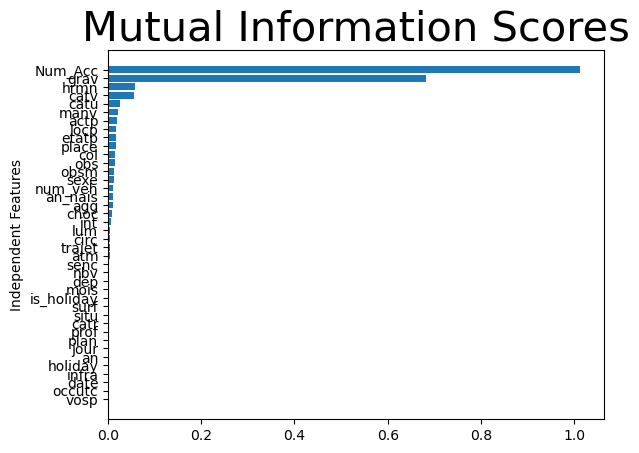

In [18]:
#See MI Scores
x = df.drop('Severe', axis=1)
y = df['Severe'] 
plot_mi_scores(x,y,mode="regression", p=None)
# IMAGE IS BELOW (mi_scores_01.png)

In [19]:
#Now let's apply label encoding.
for col in non_num_cols:
    label_encoder(x,col)

In [20]:
print(x.head())

          Num_Acc  place  catu  sexe  an_nais  trajet  locp    an  mois  jour  lum  agg  int  atm  col  dep  catr  circ  nbv  vosp  prof  plan  surf  infra  situ  senc  catv  occutc  obs  obsm  choc  manv  date  is_holiday  holiday  actp  num_veh  hrmn  grav  etatp
488  201900000230    1.0     1     1     2002     5.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   1.0     2    -1.0  0.0   2.0   3.0   1.0   154        True        2     1       14   965     3      0
489  201900000230    1.0     1     1     2000     9.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   2.0     7    -1.0  0.0   2.0   2.0  15.0   154        True        2     1        0   965     0      0
511  201900000240    1.0     1     1     1985     5.0   0.0  2019     5     8    1    1    6  2.0  3.0   64   1.0   3.0  2.0   0.0   1.0   1.0   2.0    3.0   1.0   1.0     1    -1.0  0.0   0.0   7.0  15

In [24]:
#Apply standard scaling
x = StandardScaler().fit_transform(x)
cols = [col for col in num_cols+non_num_cols if col != "Severe"]
x = pd.DataFrame(x, columns=cols)
print(x.head())

    Num_Acc     place      catu      sexe   an_nais    trajet      locp        an      mois      jour       lum       agg       int       atm       col       dep      catr      circ      nbv      vosp      prof      plan      surf     infra      situ      senc      catv    occutc       obs      obsm      choc      manv  is_holiday  actp   num_veh      hrmn      grav     etatp      date   holiday
0  1.373472 -0.347265 -0.650713 -0.678512  0.307611  0.576342 -0.082346  1.373524 -0.548663  2.383841 -0.709827 -1.142749  1.436931 -0.383365 -0.495445 -1.277057 -0.186170  0.137868 -0.08567 -0.215251 -0.270186  0.896476 -0.306727  2.896409 -0.281833  0.765437 -0.816220 -0.533436 -0.434489  0.502513  0.035029 -0.674084    1.360261   0.0 -1.004168 -0.447146  0.541646  0.381552  1.097305 -1.744273
1  1.373472 -0.347265 -0.650713 -0.678512  0.287136  2.091483 -0.082346  1.373524 -0.548663  2.383841 -0.709827 -1.142749  1.436931 -0.383365 -0.495445 -1.277057 -0.186170  0.137868 -0.08567 -0.215251 -

In [26]:
#Now let's build the model and see the RMSE value.
lm = LinearRegression()
rmse = np.mean(np.sqrt(-cross_val_score(lm, x, y, cv=5, scoring="neg_mean_squared_error")))
print(f"RMSE (only 39 original features): {rmse}")  #  0.154

RMSE (only 39 original features): 0.154147171605275


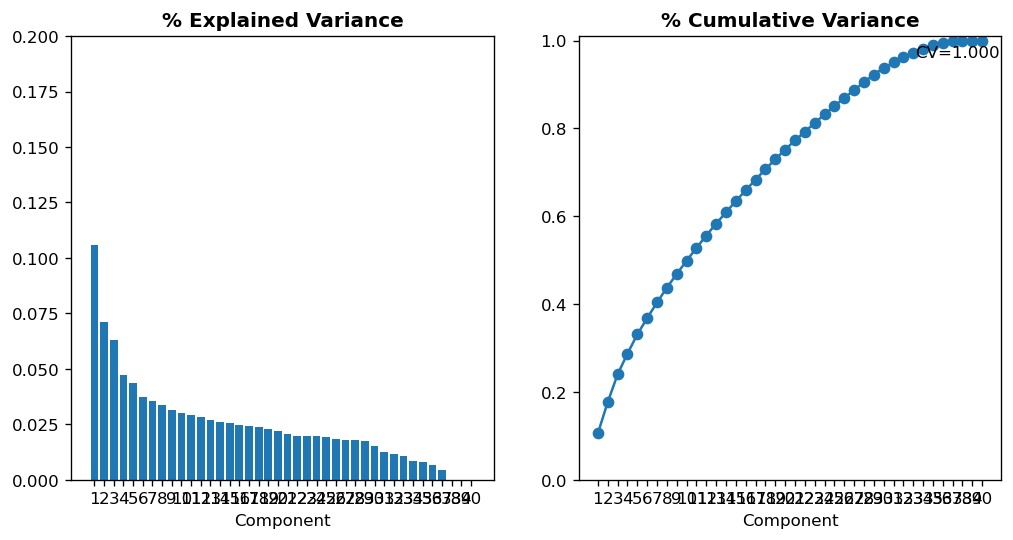

In [27]:
#Let apply PCA. You should standardize your x values.
#To do this, set standardize parameter to True
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=None)
#and plot pca variance graph
plot_pca_variance(pca)
# IMAGE IS BELOW (variance_01.png)

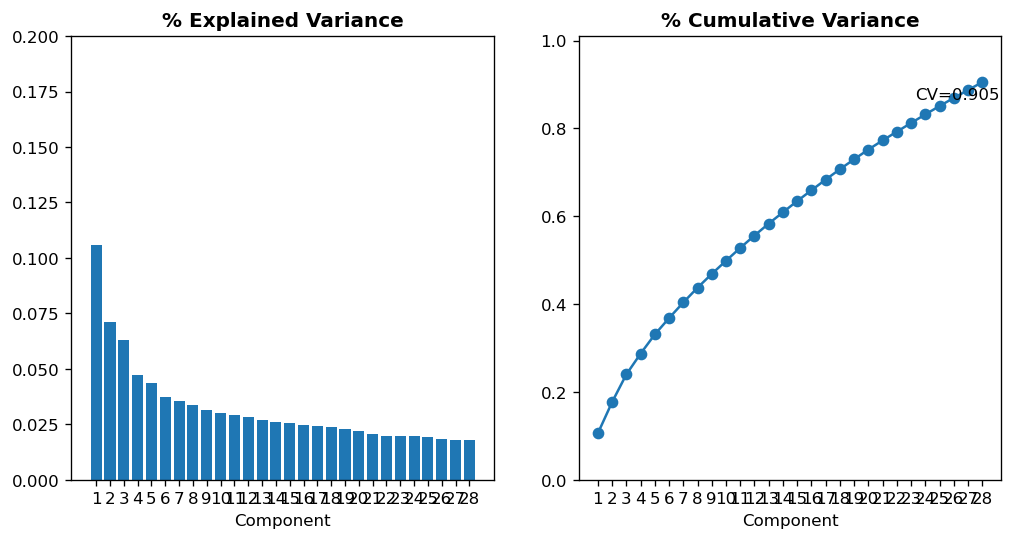

In [33]:
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=28
                                 )
plot_pca_variance(pca)


In [34]:
print(x_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14      PC15      PC16      PC17      PC18      PC19      PC20      PC21      PC22      PC23      PC24      PC25      PC26      PC27      PC28
0 -3.221382 -0.370196 -0.591557  0.711922  0.301758  0.426771 -1.276918  0.246321 -1.323522  1.249288  1.190829 -0.664032 -2.594060  1.041151 -0.801816 -0.602184 -1.451943  0.292729  0.091042 -0.090627 -0.163989  0.658989  0.818917 -0.146050  1.075005 -0.228537  0.459619  0.845678
1 -3.925411 -0.570521 -0.896445  0.249340  0.227875  1.199388 -1.061644 -0.020030 -3.062490 -0.021942  0.931505 -0.830957 -2.255462  1.500498 -0.299759  0.339010 -1.013795 -0.672253  0.334904 -0.529882 -0.501598  0.195859 -0.194138 -0.553649 -0.071725 -0.681760  0.009941  0.755946
2 -3.297329 -0.352208  0.438753  0.708463 -1.403417  0.048793  1.489123 -0.355635 -2.275195 -0.352192  0.680097  0.943387 -2.512397 -0.669640  0.130529 -0

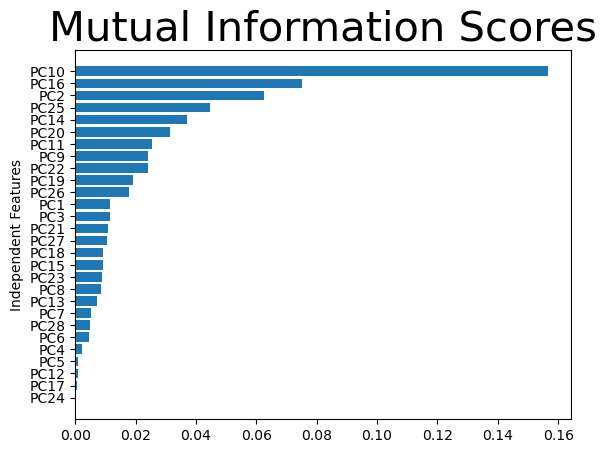

In [35]:
# MI Scores of principal components
plot_mi_scores(x_pca,y, mode="regression", p=None)


In [49]:
#print(loadings)

In [48]:
# Loop through the columns and find positive rows for each column
for column in loadings.columns:
    positive_rows = loadings.index[loadings[column] > 0]
    print(f"Positive rows for column '{column}':")
    print(positive_rows)

Positive rows for column 'PC1':
Index(['catu', 'sexe', 'locp', 'lum', 'agg', 'col', 'catr', 'occutc', 'hrmn', 'date', 'holiday'], dtype='object')
Positive rows for column 'PC2':
Index(['Num_Acc', 'place', 'catu', 'sexe', 'an_nais', 'trajet', 'locp', 'an', 'lum', 'agg', 'atm', 'col', 'dep', 'catr', 'vosp', 'prof', 'plan', 'surf', 'situ', 'senc', 'catv', 'obs', 'is_holiday', 'actp', 'num_veh', 'hrmn', 'date', 'holiday'], dtype='object')
Positive rows for column 'PC3':
Index(['place', 'catu', 'sexe', 'an_nais', 'lum', 'atm', 'col', 'circ', 'nbv', 'prof', 'plan', 'surf', 'situ', 'obs', 'choc', 'num_veh', 'date'], dtype='object')
Positive rows for column 'PC4':
Index(['Num_Acc', 'place', 'catu', 'sexe', 'an_nais', 'locp', 'an', 'mois', 'jour', 'atm', 'circ', 'nbv', 'prof', 'plan', 'surf', 'infra', 'senc', 'obsm', 'choc', 'is_holiday', 'actp', 'hrmn', 'grav', 'etatp', 'holiday'], dtype='object')
Positive rows for column 'PC5':
Index(['mois', 'jour', 'lum', 'agg', 'int', 'atm', 'col', 'dep', 

In [57]:
# Based on the loadings 11 pca weer choosen (based on teh graphcis )
df1= pd.DataFrame()
# Create new features based on positive columns
x['new_feature1'] = loadings['PC10'][loadings['PC10'] > 0]
x['new_feature1'] = loadings['PC10'][loadings['PC10'] > 0]
x['new_feature2'] = loadings['PC16'][loadings['PC16'] > 0]
x['new_feature3'] = loadings['PC2'][loadings['PC2'] > 0]
x['new_feature4'] = loadings['PC25'][loadings['PC25'] > 0]
x['new_feature5'] = loadings['PC14'][loadings['PC14'] > 0]
x['new_feature6'] = loadings['PC20'][loadings['PC20'] > 0]
x['new_feature8'] = loadings['PC9'][loadings['PC9'] > 0]
x['new_feature9'] = loadings['PC22'][loadings['PC22'] > 0]
x['new_feature10'] = loadings['PC19'][loadings['PC19'] > 0]
x['new_feature11'] = loadings['PC26'][loadings['PC26'] > 0]

# Fill NaN values with 0 if necessary
x.fillna(0, inplace=True)

# Print the DataFrame to see the new features
print(x)

        Num_Acc     place      catu      sexe   an_nais    trajet      locp        an      mois      jour       lum       agg       int       atm       col       dep      catr      circ       nbv      vosp      prof      plan      surf     infra      situ      senc      catv    occutc       obs      obsm      choc      manv  is_holiday  actp   num_veh      hrmn      grav     etatp      date   holiday  new_feature1  new_feature2  new_feature3  new_feature4  new_feature5  new_feature6  \
0      1.373472 -0.347265 -0.650713 -0.678512  0.307611  0.576342 -0.082346  1.373524 -0.548663  2.383841 -0.709827 -1.142749  1.436931 -0.383365 -0.495445 -1.277057 -0.186170  0.137868 -0.085670 -0.215251 -0.270186  0.896476 -0.306727  2.896409 -0.281833  0.765437 -0.816220 -0.533436 -0.434489  0.502513  0.035029 -0.674084    1.360261   0.0 -1.004168 -0.447146  0.541646  0.381552  1.097305 -1.744273           0.0           0.0           0.0           0.0           0.0           0.0   
1      1.373472 -0

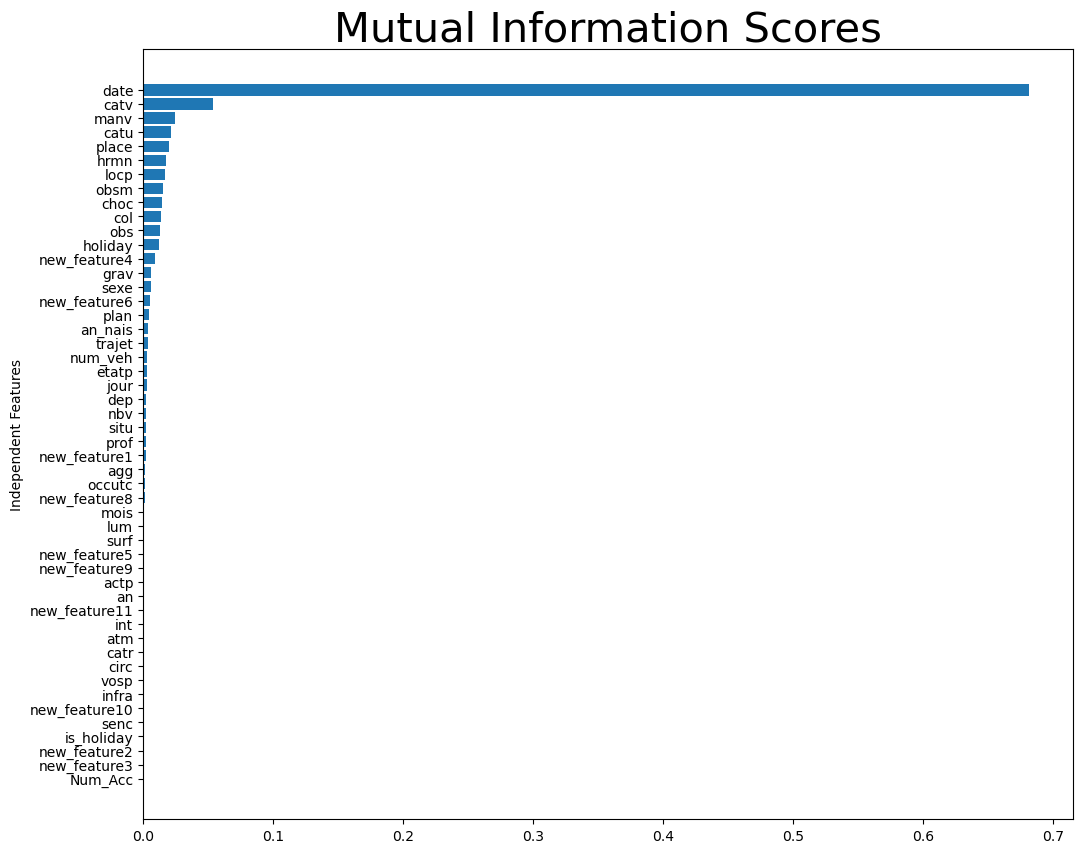

In [60]:
#Check MI Scores after feature engineering.
plt.figure(figsize=(12, 10))
plot_mi_scores(x,y,mode="regression", p=None)

<Figure size 2000x1000 with 0 Axes>

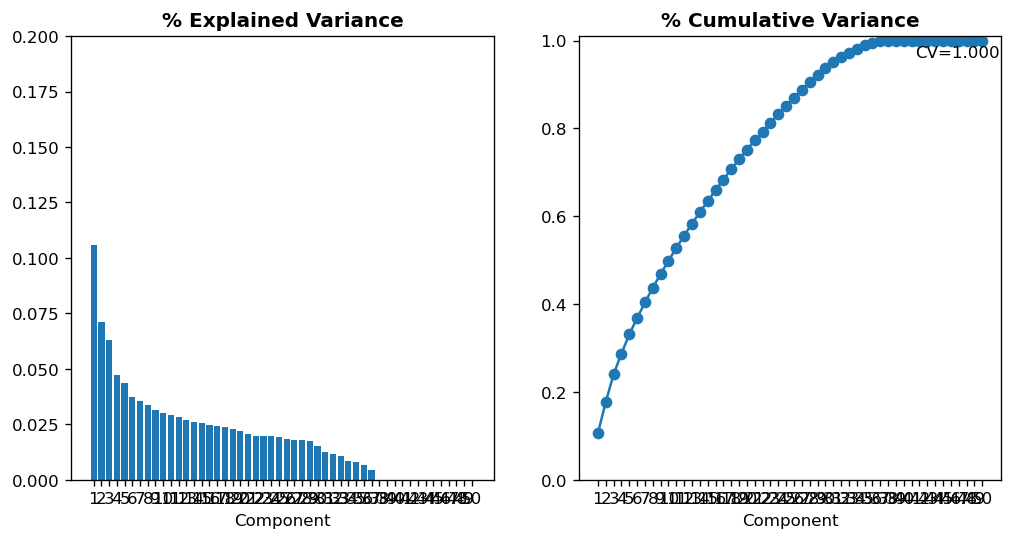

In [62]:
#Now let's look at explained and cumulative variance and decide n_components
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=None)
plt.figure(figsize=(20, 10))
plot_pca_variance(pca)


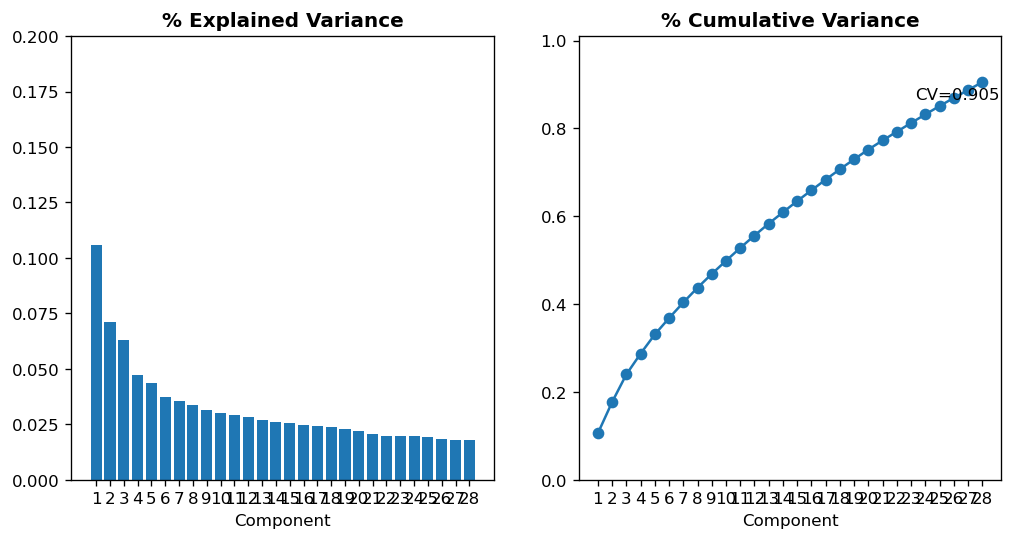

In [72]:
#Let's use 28 principal components since cumulative variance 90.5%
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=28)
plot_pca_variance(pca)

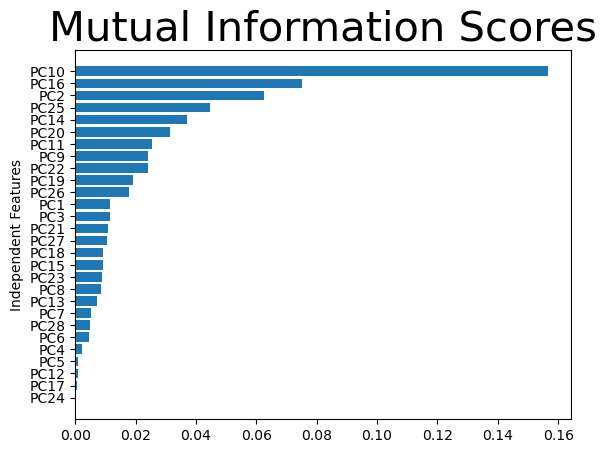

In [73]:
#Let's look at MI Scores again.
plot_mi_scores(x_pca,y, mode="regression", p=None)

In [77]:
# Encode, scale and concate categorical columns to x_pca
x_final = encode_scale_concate(x_pca, df, columns=non_num_cols, encoder='label', standardize=True)
print(x_final.head())




lm = LinearRegression()
rmse = np.mean(np.sqrt(-cross_val_score(lm, x_final, y, cv=5, scoring="neg_mean_squared_error")))
print(f"RMSE (28 PC + 2 categorical features): {rmse}")  #  0.172

        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14      PC15      PC16      PC17      PC18      PC19      PC20      PC21      PC22      PC23      PC24      PC25      PC26      PC27      PC28      date   holiday
0 -3.221382 -0.370196 -0.591557  0.711922  0.301758  0.426771 -1.276918  0.246321 -1.323522  1.249288  1.190829 -0.664032 -2.594060  1.041151 -0.801816 -0.602184 -1.451943  0.292729  0.091042 -0.090627 -0.163989  0.658989  0.818917 -0.146050  1.075005 -0.228537  0.459619  0.845678  1.360261 -1.004168
1 -3.925411 -0.570521 -0.896445  0.249340  0.227875  1.199388 -1.061644 -0.020030 -3.062490 -0.021942  0.931505 -0.830957 -2.255462  1.500498 -0.299759  0.339010 -1.013795 -0.672253  0.334904 -0.529882 -0.501598  0.195859 -0.194138 -0.553649 -0.071725 -0.681760  0.009941  0.755946  1.360261 -1.004168
2 -3.297329 -0.352208  0.438753  0.708463 -1.403417  0.048793  1.489123 -0.355635 -2.275195 -0

In [76]:
x_scaled = StandardScaler().fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled = encode_scale_concate(x_scaled, df, non_num_cols, standardize=True, encoder="label")
print(x_scaled.head())

lm = LinearRegression()
rmse = np.mean(np.sqrt(-cross_val_score(lm, x_scaled, y, cv=5, scoring="neg_mean_squared_error")))
print(f"RMSE (19 original + 3 derived features): {rmse}") 

    Num_Acc     place      catu      sexe   an_nais    trajet      locp        an      mois      jour       lum       agg       int       atm       col       dep      catr      circ      nbv      vosp      prof      plan      surf     infra      situ      senc      catv    occutc       obs      obsm      choc      manv  is_holiday  actp   num_veh      hrmn      grav     etatp      date   holiday  new_feature1  new_feature2  new_feature3  new_feature4  new_feature5  new_feature6  new_feature8  \
0  1.373472 -0.347265 -0.650713 -0.678512  0.307611  0.576342 -0.082346  1.373524 -0.548663  2.383841 -0.709827 -1.142749  1.436931 -0.383365 -0.495445 -1.277057 -0.186170  0.137868 -0.08567 -0.215251 -0.270186  0.896476 -0.306727  2.896409 -0.281833  0.765437 -0.816220 -0.533436 -0.434489  0.502513  0.035029 -0.674084    1.360261   0.0 -1.004168 -0.447146  0.541646  0.381552  1.097305 -1.744273           0.0           0.0           0.0           0.0           0.0           0.0           0.0   


In [80]:
#df.info()
y= df["Severe"]
x = df.drop(["Severe"], axis =1)
print(x.head())

          Num_Acc  place  catu  sexe  an_nais  trajet  locp    an  mois  jour  lum  agg  int  atm  col  dep  catr  circ  nbv  vosp  prof  plan  surf  infra  situ  senc  catv  occutc  obs  obsm  choc  manv        date  is_holiday        holiday  actp  num_veh  hrmn  grav  etatp
488  201900000230    1.0     1     1     2002     5.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   1.0     2    -1.0  0.0   2.0   3.0   1.0  2019-05-30        True  Ascension Day     1       14   965     3      0
489  201900000230    1.0     1     1     2000     9.0   0.0  2019     5    30    1    1    4  1.0  3.0   17   3.0   2.0  2.0   0.0   1.0   2.0   1.0    5.0   1.0   2.0     7    -1.0  0.0   2.0   2.0  15.0  2019-05-30        True  Ascension Day     1        0   965     0      0
511  201900000240    1.0     1     1     1985     5.0   0.0  2019     5     8    1    1    6  2.0  3.0   64   1.0   3.0  2.0   0.0   1.0   1.0   2.0    3.0   1.0   1.

In [93]:
x.head()
x= x.drop(["date","is_holiday","holiday"], axis =1)

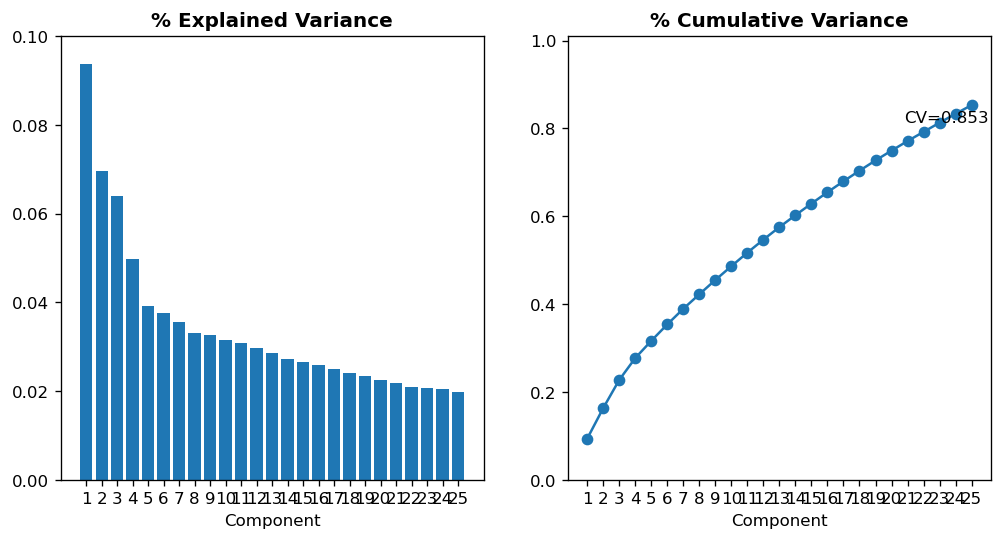

In [97]:
#Since there is no categorical variable, we can directly apply PCA.
#We will set n_components to 3 since we want 3D visualization.
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=25)
#As can be seen from the graphs below, when we have 3 components we 
#can explain 72.6% variance. It is actually bad. But we don't care 
#here because we just want to visualize in 3D.
plot_pca_variance(pca)  #image is below

Unsupported number of PCA components. 2 or 3 components are required.
